In [1]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import re
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [2]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [3]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

NOISE_LEVEL = 0.8

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

In [5]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [6]:
all_timesteps = torch.tensor(range(diffuser.diffmodel.sde.N))
all_noise_levels = diffuser.diffmodel.sde.noise_level(all_timesteps).reshape(-1)
closest_timestep = torch.argmin(torch.abs(all_noise_levels - NOISE_LEVEL))
closest_timestep, diffuser.diffmodel.sde.noise_level(closest_timestep).reshape(-1)

(tensor(217, device='cuda:0'), tensor([0.8000], device='cuda:0'))

In [7]:
theta_fid = torch.tensor([[70, 0.0321]]).to(device)
#theta = diffuser.diffmodel.ps.sample_theta(1).to(device)
theta = theta_fid
theta[0], theta.shape

(tensor([7.0000e+01, 3.2100e-02], device='cuda:0'), torch.Size([1, 2]))

## Different images of the problem

In [8]:
image = diffuser.test_dataloader.dataset[0].unsqueeze(0).unsqueeze(1).to(device)
image.shape

torch.Size([1, 1, 256, 256])

In [9]:
ps_theta = diffuser.diffmodel.ps(theta) ## You can chose theta close to the mean and see if there is a difference
sqrt_ps_theta = torch.sqrt(ps_theta)

In [10]:
noisy_image, mean_noisy_image, added_noise = diffuser.diffmodel.sde.sampling(image, closest_timestep, sq_ps=sqrt_ps_theta)

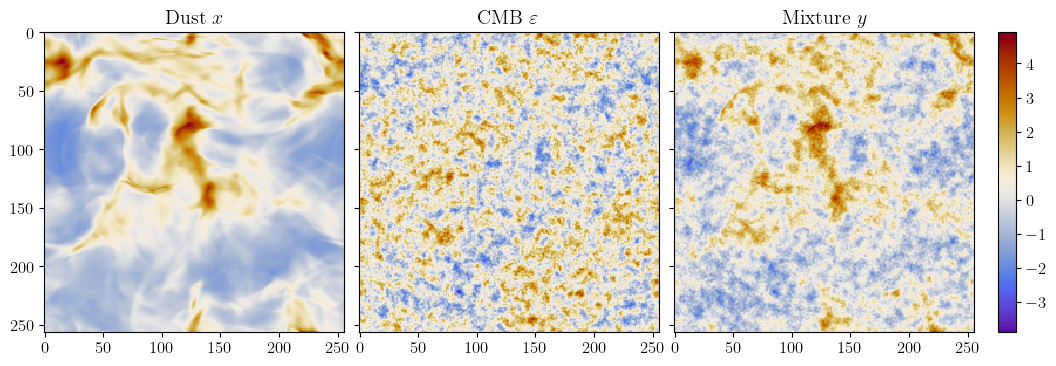

In [11]:
x = image[0, 0].cpu().numpy()
e = added_noise[0, 0].cpu().numpy()
y = noisy_image[0, 0].cpu().numpy()

vmin = np.min([x, e, y])
vmax = np.max([x, e, y])
cmap = 'cmb'

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
im0 = axs[0].imshow(x, cmap=cmap, vmin=vmin, vmax=vmax)
im1 = axs[1].imshow(e, cmap=cmap, vmin=vmin, vmax=vmax)
im2 = axs[2].imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title('Dust $x$')
axs[1].set_title(r'CMB $\varepsilon$')
axs[2].set_title('Mixture $y$')
fig.colorbar(im0, cax=fig.add_axes([0.92, 0.12, 0.015, 0.75])) # left, bottom, width, height
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save_fig:
    fig.savefig('figs/data.pdf', bbox_inches='tight')

## Gen samples vs training samples

In [12]:
max_to_plot = 3

In [13]:
## Get max_to_plot samples from results_*
pattern = r'results_(\d+)'
l = os.listdir(os.path.join(diffuser.config["sample_dir"],diffuser.config["model_id"]))
l_samples = []
for file in l:
    match = re.search(pattern, file)
    if match:
        l_samples.append(file)
if len(l_samples) > max_to_plot:
    l_samples = l_samples[:max_to_plot]

## Collect all the samples from results_*
all_img = [np.load(os.path.join(diffuser.config["sample_dir"],diffuser.config["model_id"],sample),allow_pickle=True) for sample in l_samples]
if len(all_img[0].shape) == 2:
    all_img = np.concatenate([img[np.newaxis,np.newaxis,:,:] for img in all_img], axis = 0)
elif len(all_img[0].shape) == 3:
    all_img = np.concatenate([img[np.newaxis,:,:,:] for img in all_img], axis = 0)
elif len(all_img[0].shape) >= 4:
    all_img = np.concatenate([img for img in all_img], axis = 0)

## Get max_to_plot samples from the dataset
dataloader = diffuser.train_dataloader
batch = next(iter(dataloader))
if len(batch) < max_to_plot:
    max_to_plot = len(batch)
dataset = batch[:max_to_plot]
if len(dataset.shape)< len(all_img[0].shape)+1:
    dataset = dataset.unsqueeze(1)

## Plot the images using plot_and_save_lines
label_samp = diffuser.config["model_id"]
try:
    label_dataset = diffuser.config["dataloaders"]["dataset"]["name"]
except:
    label_dataset = "Dataset"

In [14]:
original_samples = dataset.cpu().numpy().squeeze()
generated_samples = all_img.squeeze()

print(original_samples.shape, generated_samples.shape)

(3, 256, 256) (3, 256, 256)


/tmp/ipykernel_3992840/1623462288.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


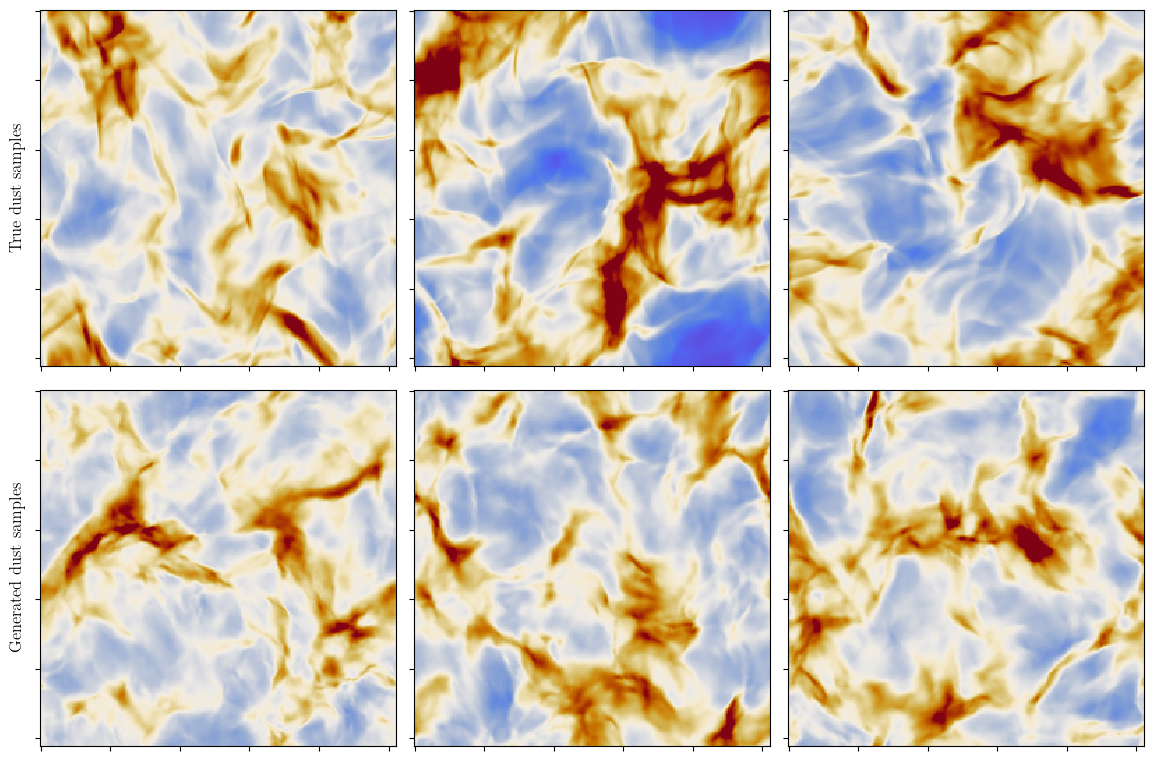

In [15]:
dat = np.concatenate([original_samples, generated_samples], axis = 0)

vmin = dat.mean() - 3*dat.std()
vmax = dat.mean() + 3*dat.std()

cmap = 'cmb'

fig, axs = plt.subplots(2, max_to_plot, figsize=(max_to_plot*3.9, 7.8), sharex=True, sharey=True)

for i in range(max_to_plot):
    im0 = axs[0,i].imshow(original_samples[i], cmap=cmap, vmin=vmin, vmax=vmax)
    im1 = axs[1,i].imshow(generated_samples[i], cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    axs[1,i].set_xticklabels([])
    axs[1,i].set_yticklabels([])
axs[0,0].set_ylabel("True dust samples")
axs[1,0].set_ylabel("Generated dust samples")
fig.tight_layout()

if save_fig:
    fig.savefig('figs/samples.pdf', bbox_inches='tight')

fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.show()